### CheckPoint  1  - Data cleaning
##### Submitted by Vedavyas Burli
- Load the companies and rounds data  into two data frames and name them companies and rounds2 respectively



In [4]:
#import numpy and pandas library
import pandas as pd
import numpy as np
import chardet

In [5]:
#Refer  https://docs.python.org/2.4/lib/standard-encodings.html encoding 
#Read csv and apply encoding palmos


companies = pd.read_csv("companies.csv",encoding = "palmos")
rounds2 = pd.read_csv("rounds2.csv",encoding = "palmos")
#Below dataframe will be used in checkpoint 4 sector analysis
sector_mapping = pd.read_csv('mapping.csv',encoding='palmos')

print(companies.shape)
print(rounds2.shape)
#print(companies.head(10))
#print(rounds2.head(10))


(66368, 10)
(114949, 6)


### 1. How many unique companies are present in rounds2?
-  Convert 'company_permalink' column to lower case and apply nunique function
- nunique function - Return Series with number of distinct observation
- Below observation shows that, there are 66368 unique companies present in rounds2

In [6]:
rounds2.company_permalink.str.lower().nunique(dropna=True)

66368

### 2. How many unique companies are present in companies?
- Convert 'permalink' column to lower case and apply nunique function
- Below observation shows that there are 66368 unique companies present in companies

In [7]:
companies.permalink.str.lower().nunique(dropna=True)

66368

### 3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
- Applying is_unique on companies dataframe  to check if column is unique key
- True is uniue key and False is not a unique key
- Below execution shows that Only 'permalink' column is unique column in companies dataframe

In [9]:
print("permalink",companies.permalink.is_unique)
print("-- If above function returns true which means it's unique col in companies dataframe --")

permalink True
-- If above function returns true which means it's unique col in companies dataframe --


### 4. Are there any companies in the rounds2 file which are not present in companies?
- Apply "isin" function to check if any companies in the rounds2 file which are present in companies. Use ~ functionality to return companies in rounds2 which are not present in companies dataframe.
- Below execution retrun that there are no companies in rounds2 which are not present in companies DF

In [10]:
rounds2[~rounds2.company_permalink.str.lower().isin(companies.permalink.str.lower())]

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd


### 5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?
- convert 'company_permalink' column of rounds2 to lowercase and  'permalink' column of companies  to lowercase 
- Apply merge function to merge both dataframe.
- inner ,left_on=company_permalink, right_on=permalink
- Return the observation after merge

In [11]:
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()

companies['permalink'] = companies['permalink'].str.lower()

In [12]:
master_frame = pd.merge(rounds2, companies,left_on='company_permalink',right_on='permalink',how='inner')
master_frame.shape

(114949, 16)

#### Remove duplicate column
- After mergeing both the tables we have two dulicate columns - company_permalink and permalink.
- we can delete permalink from master_frame table

In [13]:
master_frame = master_frame.drop('permalink',axis=1)

#### Treating Missing Values

- As we can see from the below execution we have calculated percentage of missing values 
- Based on our observation we can see that 'funding_round_code' and 'founded_at' has approximately 73 % and 18 % of missing values respectively.

> It is impossible to delete or impute rows corresponding to large number of missing values. Instead we can remove columns from the tables
>> - Another column 'raised_amount_usd' has around 17 % missing values, deleting the rows can impact the future results.
>> - Other column like 'country_code','state_code','region','city','homepage_url','category_list' have 2-10 % missing values dropping Nan rows might impact calculating total of raised_amount_usd which is used for funding_round_type.

In [14]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

company_permalink           0.00
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         72.91
funded_at                   0.00
raised_amount_usd          17.39
name                        0.00
homepage_url                5.34
category_list               2.97
status                      0.00
country_code                7.55
state_code                  9.52
region                      8.84
city                        8.84
founded_at                 17.85
dtype: float64

In [15]:
master_frame = master_frame.drop('founded_at',axis=1)
master_frame = master_frame.drop('funding_round_code',axis=1)


In [16]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)
master_frame.funding_round_type.unique()

array(['venture', 'seed', 'undisclosed', 'equity_crowdfunding',
       'convertible_note', 'private_equity', 'debt_financing', 'angel',
       'grant', 'secondary_market', 'post_ipo_equity', 'post_ipo_debt',
       'product_crowdfunding', 'non_equity_assistance'], dtype=object)

### Checkpoint 2 -  Funding Type Analysis
- Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)
- group by funding_round_type and apply mean on raised_amount_usd 
- create new dataframe - funding_type_dataframe for only above mentioned funding types 

In [17]:
pd.options.display.float_format = '{:.2f}'.format
#funding_type_dataframe is created to calculate the to find  most suitable for Spark Funds
funding_type_dataframe = pd.DataFrame(master_frame.loc[(master_frame['funding_round_type'] == 'venture') | 
                 (master_frame['funding_round_type'] == 'angel') |
                 (master_frame['funding_round_type'] == 'seed')|
                (master_frame['funding_round_type'] == 'private_equity'),:].groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=False))
                

- Considering that Spark Funds wants to invest between 5 to 15 million USD per investment round, which investment type is the most suitable for it? Identify the investment type and, for further analysis, filter the data so it only contains the chosen investment type.

In [19]:
funding_type_dataframe.reset_index(inplace=True)
funding_type_dataframe.head()
'''
As we all now Spark funds  wants to invest between 5 to 15 million USD per round of investment
After filtering the data with above invsetment range we will get Venture  as best suitable funding type for Spark funds
'''
funding_type_dataframe.loc[(funding_type_dataframe['raised_amount_usd'] > 5000000.0) & (funding_type_dataframe['raised_amount_usd'] < 15000000.0)]

,index,funding_round_type,raised_amount_usd
1,1,venture,11748949.13


### Identify the investment type and, for further analysis, filter the data so it only contains the chosen investment type.
- Based on above analysis 'venture' is best investment type for Spark fund to invest between 5 to 15 million USD per investment round
- filter the data and create new dataframe venture funding type only

In [20]:
venture_frame = master_frame.loc[(master_frame['funding_round_type'] == 'venture'),:]
venture_frame.shape

(55494, 13)

### Checkpoint 3 - Country Analysis
>This is the second goal of analysis — country analysis.

- Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)
- For the chosen investment type, make a data frame named top9 with the top nine countries


> - Identify the top three English-speaking countries in the data frame top9. https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language
- > USA - English speaking	
- > CHN - Not english speaking
- > GBR - English speaking
- > IND - English speaking(educational point of view)
> - Consider USA,GBR and IND are top three english speaking country
> - Result: Based on above wiki page and data from top9 list with highest investment are USA,GBR and IND

In [21]:
top9 = pd.DataFrame(venture_frame.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).head(n=9))
top9.reset_index(inplace=True)
top9.head(n=10)

,country_code,raised_amount_usd
0,USA,422510842796.00
1,CHN,39835418773.00
2,GBR,20245627416.00
3,IND,14391858718.00
4,CAN,9583332317.00
5,FRA,7259536732.00
6,ISR,6907514579.00
7,DEU,6346959822.00
8,JPN,3363676611.00


### Checkpoint 4: Sector Analysis 1
> This is the third goal of analysis — sector analysis.

- Extract the primary sector of each category list from the category_list column.
- Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors

In [25]:
venture_frame.loc[:,'primary_sector'] = venture_frame.category_list.str.split('|').str[0].copy()

venture_frame.loc[:,'primary_sector'] = venture_frame.primary_sector.str.upper().copy()
venture_frame.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,company_permalink,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,name,homepage_url,category_list,status,country_code,state_code,region,city,primary_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.00,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,MEDIA
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,14-10-2014,nan,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,APPLICATION PLATFORMS
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,30-01-2014,3406878.00,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,APPS
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,19-03-2008,2000000.00,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,CURATED WEB
5,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,24-07-2014,nan,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,SOFTWARE


In [26]:
sector_mapping = pd.read_csv('mapping.csv',encoding='palmos')

In [27]:
sector_mapping.replace({'category_list':'0'},{'category_list':'na'},regex=True,inplace=True)

In [28]:
sector_mapping = sector_mapping.melt(id_vars="category_list",var_name="main_sector")

In [29]:
sector_mapping = sector_mapping.loc[~(sector_mapping.value == 0)]

In [30]:
sector_mapping = sector_mapping.loc[~(sector_mapping.main_sector == 'Blanks')]

In [31]:
sector_mapping.category_list = sector_mapping.category_list.str.upper()

In [32]:
sector_mapping.drop(columns='value')

,category_list,main_sector
8,ADVENTURE TRAVEL,Automotive & Sports
14,AEROSPACE,Automotive & Sports
45,AUTO,Automotive & Sports
46,AUTOMATED KIOSK,Automotive & Sports
47,AUTOMOTIVE,Automotive & Sports
...,...,...
6121,SOCIAL RECRUITING,"Social, Finance, Analytics, Advertising"
6122,SOCIAL TELEVISION,"Social, Finance, Analytics, Advertising"
6123,SOCIAL TRAVEL,"Social, Finance, Analytics, Advertising"
6134,STOCK EXCHANGES,"Social, Finance, Analytics, Advertising"


In [33]:
venture_sector_df = pd.merge(venture_frame,sector_mapping,how = 'inner',left_on='primary_sector',right_on='category_list')

In [34]:
venture_sector_df.drop(columns=['category_list_y','value'],inplace=True)
venture_sector_df.head(10)

,company_permalink,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,name,homepage_url,category_list_x,status,country_code,state_code,region,city,primary_sector,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.00,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,MEDIA,Entertainment
1,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,06-10-2015,15000000.00,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,MEDIA,Entertainment
2,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,07-05-2013,5800000.00,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,MEDIA,Entertainment
3,/organization/90min,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,26-03-2014,18000000.00,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,MEDIA,Entertainment
4,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,06-08-2014,5000000.00,All Def Digital,http://alldefdigital.com,Media,operating,USA,CA,Los Angeles,Los Angeles,MEDIA,Entertainment
5,/organization/audiosocket,/funding-round/0959f59e3a89bc8db8c6ed9c646349fd,venture,02-05-2013,650000.00,Audiosocket,http://audiosocket.com,Media|Music|Technology,operating,USA,WA,Seattle,Seattle,MEDIA,Entertainment
6,/organization/audiosocket,/funding-round/4e3a53eec6c609943df752206070b23f,venture,02-09-2009,750000.00,Audiosocket,http://audiosocket.com,Media|Music|Technology,operating,USA,WA,Seattle,Seattle,MEDIA,Entertainment
7,/organization/audiosocket,/funding-round/bc0b412cf2fa7b739e4105ad756b47a4,venture,15-02-2012,1582300.00,Audiosocket,http://audiosocket.com,Media|Music|Technology,operating,USA,WA,Seattle,Seattle,MEDIA,Entertainment
8,/organization/babble,/funding-round/43cc678b39be3e684bb88501af05ff9b,venture,05-02-2009,2000000.00,Babble,http://www.babble.com,Media|News|Parenting,acquired,USA,NY,New York City,New York,MEDIA,Entertainment
9,/organization/babble,/funding-round/5fdb3dbeeb6eea0243702adc372130f3,venture,12-05-2009,1250000.00,Babble,http://www.babble.com,Media|News|Parenting,acquired,USA,NY,New York City,New York,MEDIA,Entertainment


In [35]:
venture_sector_df.shape

(54341, 15)

### Checkpoint 5: Sector Analysis 2

1. Now, the aim is to find out the most heavily invested main sectors in each of the three countries (for funding type FT and investments range of 5-15 M USD)
> Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. The three data frames should contain all the columns of the master_frame along with the main sector and the primary sector. 
2. Using the three data frames.
> - calculate the total number of investments
> - total amount of investments in each main sector for each of the three countries.

In [36]:
D1 = venture_sector_df.loc[venture_sector_df['country_code'] == 'USA']
D2 = venture_sector_df.loc[venture_sector_df['country_code'] == 'GBR']
D3 = venture_sector_df.loc[venture_sector_df['country_code'] == 'IND']

### Based on the analysis of the sectors, which main sectors and countries would you recommend Spark Funds to invest in
- Calculate main sector wise total investment count for top 3 countries
> 1. TNI_USA: investment count for USA
> 2. TNI_GBR: investment count for GBR
> 3. TNI_IND: investment count for IND

In [37]:
TNI_USA = pd.DataFrame(D1.groupby(by='main_sector')['main_sector'].count().rename('Total_investment_count').sort_values(ascending=False))
TNI_USA.head()

,Total_investment_count
main_sector,
Others,8763
Cleantech / Semiconductors,8268
"Social, Finance, Analytics, Advertising",7822
"News, Search and Messaging",4618
Health,3413


In [38]:
TNI_GBR = pd.DataFrame(D2.groupby(by='main_sector')['main_sector'].count().rename('Total_investment_count').sort_values(ascending=False))
TNI_GBR.head()

,Total_investment_count
main_sector,
Others,580
"Social, Finance, Analytics, Advertising",481
Cleantech / Semiconductors,466
"News, Search and Messaging",265
Entertainment,160


In [39]:
TNI_IND = pd.DataFrame(D3.groupby(by='main_sector')['main_sector'].count().rename('Total_investment_count').sort_values(ascending=False))
TNI_IND.head()

,Total_investment_count
main_sector,
Others,332
"Social, Finance, Analytics, Advertising",193
"News, Search and Messaging",154
Entertainment,90
Manufacturing,64


### Calculate main sector wise total investment amount
> 1. TIA_USA : total investment amount for USA
> 1. TIA_GBR : total investment amount for GBR
> 1. TIA_IND: total investment amount for IND

In [40]:
TIA_USA = pd.DataFrame(D1.groupby(by='main_sector')['raised_amount_usd'].sum().rename('Total_investment_amount').sort_values(ascending=False))
TIA_USA.Total_investment_amount.sum()
#TIA_USA.head(10)


419827724225.0

In [41]:
TIA_GBR = pd.DataFrame(D2.groupby(by='main_sector')['raised_amount_usd'].sum().rename('Total_investment_amount').sort_values(ascending=False))
TIA_GBR.Total_investment_amount.sum()
#TIA_GBR.head(10)

20004243770.0

In [42]:
TIA_IND = pd.DataFrame(D3.groupby(by='main_sector')['raised_amount_usd'].sum().rename('Total_investment_amount').sort_values(ascending=False))
TIA_IND.Total_investment_amount.sum()
#TIA_IND.head(10)

14261508718.0

### Merge Total investment amout and Total investment count frames of 3 countries to respective main data frames

In [43]:
D1 = pd.merge(pd.merge(D1,TNI_USA,how='inner',left_on='main_sector',right_index=True),TIA_USA,how='inner',left_on='main_sector',right_index=True)
D1.shape


(38020, 17)

In [44]:
D2 = pd.merge(pd.merge(D2,TNI_GBR,how='inner',left_on='main_sector',right_index=True),TIA_GBR,how='inner',left_on='main_sector',right_index=True)
D2.shape

(2264, 17)

In [45]:
D3 = pd.merge(pd.merge(D3,TNI_IND,how='inner',left_on='main_sector',right_index=True),TIA_IND,how='inner',left_on='main_sector',right_index=True)
D3.shape

(984, 17)

### For point 3 (top sector count-wise), which company received the highest investment?


In [46]:
D1.loc[D1['main_sector'] == 'Others'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/terascala                          13
/organization/vectormax                          12
/organization/lecere                             11
/organization/bti-systems                        10
/organization/approva                             9
                                                 ..
/organization/globalcrypto                        0
/organization/park-place-international            0
/organization/allegro-development-corporation     0
/organization/dartdevices                         0
/organization/004-technologies                    0
Name: raised_amount_usd, Length: 4884, dtype: int64

In [48]:
D2.loc[D2['main_sector'] == 'Others'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/rostima             8
/organization/electric-cloud      7
/organization/helveta             6
/organization/picochip            6
/organization/myoptique-group     5
                                 ..
/organization/casehub             0
/organization/wees                0
/organization/csl-dualcom         0
/organization/exg                 0
/organization/girl-meets-dress    0
Name: raised_amount_usd, Length: 387, dtype: int64

In [49]:
D3.loc[D3['main_sector'] == 'Others'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/flipkart                        9
/organization/myntra                          8
/organization/snapdeal                        5
/organization/canvera-digital-technologies    5
/organization/tutorvista-com                  5
                                             ..
/organization/the-beer-caf                    0
/organization/careers360                      0
/organization/karma-recycling                 0
/organization/boond                           0
/organization/travelkhana-com                 0
Name: raised_amount_usd, Length: 221, dtype: int64

### For point 4 (second best sector count-wise), which company received the highest investment?


In [50]:
D1.loc[D1['main_sector'] == 'Cleantech / Semiconductors'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/pro-pharmaceuticals           12
/organization/tigo-energy                   12
/organization/aviir                         12
/organization/covenant-surgical-partners    12
/organization/cns-response                  11
                                            ..
/organization/digital-currency-group         0
/organization/catamaran-2                    0
/organization/verdant-power                  0
/organization/pear-therapeutics              0
/organization/biodata                        0
Name: raised_amount_usd, Length: 3930, dtype: int64

In [51]:
D2.loc[D2['main_sector'] == 'Social, Finance, Analytics, Advertising'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/worldremit               6
/organization/similarweb               6
/organization/borro                    5
/organization/celltick-technologies    5
/organization/sportpursuit             5
                                      ..
/organization/tailgate-technologies    0
/organization/taskpipes                0
/organization/ascots-of-london         0
/organization/mobyko                   0
/organization/cognisess                0
Name: raised_amount_usd, Length: 313, dtype: int64

In [52]:
D3.loc[D3['main_sector'] == 'Social, Finance, Analytics, Advertising'].groupby(by='company_permalink')['raised_amount_usd'].count().sort_values(ascending=False)

company_permalink
/organization/manthan-systems    6
/organization/shopclues-com      4
/organization/komli-media        4
/organization/policybazaar       4
/organization/yepme-com          3
                                ..
/organization/findable-in        0
/organization/kae-capital        0
/organization/empower-futures    0
/organization/simpli5d           0
/organization/jombay             0
Name: raised_amount_usd, Length: 141, dtype: int64

In [53]:
df2 = pd.DataFrame(master_frame.loc[(master_frame['funding_round_type'] == 'venture') | 
                 (master_frame['funding_round_type'] == 'angel') |
                 (master_frame['funding_round_type'] == 'seed')|
                (master_frame['funding_round_type'] == 'private_equity'),:].groupby('funding_round_type')['raised_amount_usd'].sum())


In [54]:
df2

,raised_amount_usd
funding_round_type,
angel,4659255123.00
private_equity,141925436105.00
seed,16989864181.00
venture,590126216876.00


### Checkpoint 6 - Plots
- A plot showing the representative amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.
- A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (USA , GBR, and IND) very clear. 

#### Charts makes it clear that 'Venture' funding type is best suited for Spark Funds.

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


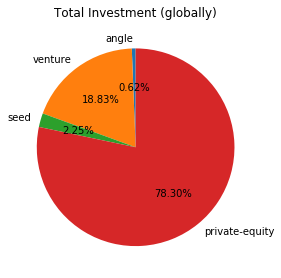

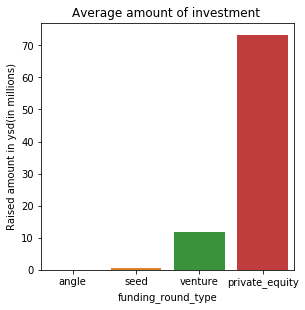

In [57]:
#subplot 1 - fractions of total investment globally
plt.figure(figsize=[10.0,10.0],frameon=True)
plt.subplot(2,2,1)
labels='angle','venture','seed','private-equity'
plt.title('Total Investment (globally)',pad=7)
plt.pie(df2,labels=labels,autopct='%1.2f%%',startangle=90)
plt.show()

# subplot 2  - average amount of investment
plt.figure(figsize=[10.0,10.0],frameon=True)
plt.subplot(2,2,2)
sns.barplot(x=master_frame['funding_round_type'],y=master_frame['raised_amount_usd']/1000000,estimator=np.mean,ci=None,order=['angle','seed','venture','private_equity'])
plt.ylabel('Raised amount in ysd(in millions)')
plt.title("Average amount of investment ")
plt.show()

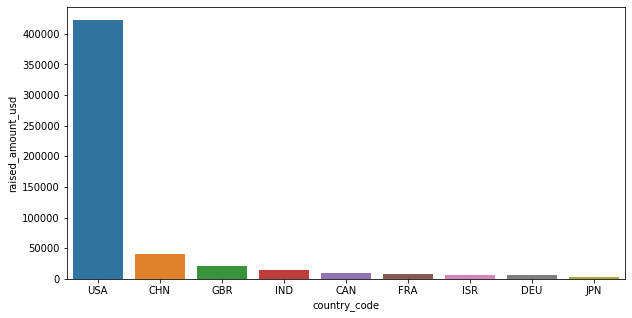

In [59]:
#Top 3 English speaking country are with highest investment
plt.figure(figsize=[10.0,5.0])
sns.barplot(x=top9['country_code'],y=top9['raised_amount_usd']/1000000)
plt.show()

In [60]:
TNI_USA.head()

,Total_investment_count
main_sector,
Others,8763
Cleantech / Semiconductors,8268
"Social, Finance, Analytics, Advertising",7822
"News, Search and Messaging",4618
Health,3413


In [61]:
TNI_USA.reset_index(inplace=True)
TNI_GBR.reset_index(inplace=True)
TNI_IND.reset_index(inplace=True)

In [63]:
TNI_USA = TNI_USA.sort_values(by='Total_investment_count',ascending=False).head(3)
TNI_USA['Country'] = 'USA'

TNI_GBR = TNI_GBR.sort_values(by='Total_investment_count',ascending=False).head(3)
TNI_GBR['Country'] = 'GBR'

TNI_IND = TNI_IND.sort_values(by='Total_investment_count',ascending=False).head(3)
TNI_IND['Country'] = 'IND'


In [64]:
TNI = pd.merge(pd.merge(TNI_USA,TNI_GBR,how='outer'),TNI_IND,how='outer')
TNI.Country

0    USA
1    USA
2    USA
3    GBR
4    GBR
5    GBR
6    IND
7    IND
8    IND
Name: Country, dtype: object

#### A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). This plot should clearly display the top 3 sectors each in USA,GBR and IND 

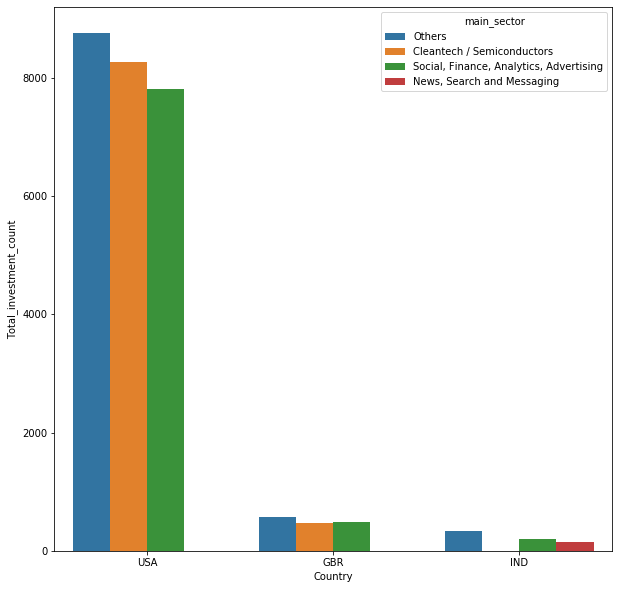

In [65]:
plt.figure(figsize=[10.0,10.0])
sns.barplot(data=TNI,x='Country',y='Total_investment_count',hue='main_sector')